# Binary Classification

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### Device Agnostic Code

In [276]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

### Data PreProcessing

In [277]:
data = pd.read_csv('./dataset-classification/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [278]:
data = data[['RestingBP', 'Cholesterol', 'MaxHR', 'HeartDisease']]
data.head()

,RestingBP,Cholesterol,MaxHR,HeartDisease
0,140,289,172,0
1,160,180,156,1
2,130,283,98,0
3,138,214,108,1
4,150,195,122,0


In [279]:
X = data[['RestingBP', 'Cholesterol', 'MaxHR']]
y = data['HeartDisease']

y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

In [280]:
# convert sex to numerical value

X = X.replace({'M':1, 'F':0})

X.head()

,RestingBP,Cholesterol,MaxHR
0,140,289,172
1,160,180,156
2,130,283,98
3,138,214,108
4,150,195,122


In [281]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X)

features_scaled

array([[ 0.41090889,  0.82507026,  1.38292822],
       [ 1.49175234, -0.17196105,  0.75415714],
       [-0.12951283,  0.7701878 , -1.52513802],
       ...,
       [-0.12951283, -0.62016778, -0.85706875],
       [-0.12951283,  0.34027522,  1.4615246 ],
       [ 0.30282455, -0.21769643,  1.42222641]])

### Split the data

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

### Convert Dataframes to Tensors

In [283]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [284]:
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.float32).to(device)

In [285]:
X_train.shape, y_train.shape, X_train.dim(), y_train.dim()

(torch.Size([780, 3]), torch.Size([780]), 2, 1)

In [286]:
X_train[:5], y_train[:5]

(tensor([[130.,   0., 160.],
         [150., 226., 114.],
         [130., 184., 100.],
         [160.,   0., 121.],
         [130., 251., 110.]]),
 tensor([0., 0., 0., 1., 0.]))

### Creating Model

In [287]:
class myModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=3, out_features=15)
        self.layer2 = nn.Linear(in_features=15, out_features=8)
        self.layer3 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [288]:
model = myModel().to(device)

model

myModel(
  (layer1): Linear(in_features=3, out_features=15, bias=True)
  (layer2): Linear(in_features=15, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

### Calculate Accuracy Function

In [289]:
def accuracy_fn(y_pred, y_actual):
    assert y_pred.shape == y_actual.shape
    correct = torch.eq(y_pred, y_actual).sum().item()
    accuracy = (correct / len(y_actual)) 
    return accuracy

### Setup Loss Function and Optimizer

In [290]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### Plotting Function

In [291]:
def plot_fn(x, y, label, title):
    plt.subplots(1, 2, figsize=(12, 5))
    plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

In [292]:
def plot_side_by_side(epochs, loss, accuracy, label_train_test):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot on the first subplot (left)
    ax[0].plot(epochs, loss, label='Loss', color='blue')
    ax[0].set_title(f'{label_train_test} Loss Over Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot on the second subplot (right)
    ax[1].plot(epochs, accuracy, label='Accuracy', color='red')
    ax[1].set_title(f'{label_train_test} Accuracy Over Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

### Training the model

In [293]:
X_train.size(), y_train.size(), X_test.size(), y_test.size()

(torch.Size([780, 3]),
 torch.Size([780]),
 torch.Size([138, 3]),
 torch.Size([138]))

In [294]:
train_loss, train_accu, test_loss, test_accu, epoch_arr = [], [], [], [], []

In [295]:
epochs = 10000

for epoch in range(epochs):

    model.train()

    # forward pass
    y_logits = model(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss and accuracy
    loss = loss_fn(y_logits.squeeze(), y_train)
    accu = accuracy_fn(y_pred.squeeze(), y_train)

    # optimizer
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # step the optimizer
    optimizer.step()

    # calulcating loss and accuracy for test data
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))

        loss_te = loss_fn(test_logits.squeeze(), y_test)
        accu_te = accuracy_fn(test_pred.squeeze(), y_test)
    
    if epoch % 500 == 0:
        print(f'Epoch: {epoch} | Train Loss: {loss:.2f} | Train Accuracy: {accu:.2f} |Test Loss: {loss_te:.2f} | Test Accuracy: {accu_te:.2f}')
        train_loss.append(loss)
        train_accu.append(accu)
        test_loss.append(loss_te)
        test_accu.append(accu_te)
        epoch_arr.append(epoch)

Epoch: 0 | Train Loss: 7.68 | Train Accuracy: 0.54 |Test Loss: 3.38 | Test Accuracy: 0.63
Epoch: 500 | Train Loss: 0.59 | Train Accuracy: 0.70 |Test Loss: 0.51 | Test Accuracy: 0.78
Epoch: 1000 | Train Loss: 0.58 | Train Accuracy: 0.70 |Test Loss: 0.51 | Test Accuracy: 0.80
Epoch: 1500 | Train Loss: 0.58 | Train Accuracy: 0.69 |Test Loss: 0.51 | Test Accuracy: 0.80
Epoch: 2000 | Train Loss: 0.57 | Train Accuracy: 0.70 |Test Loss: 0.51 | Test Accuracy: 0.79
Epoch: 2500 | Train Loss: 0.57 | Train Accuracy: 0.70 |Test Loss: 0.51 | Test Accuracy: 0.78
Epoch: 3000 | Train Loss: 0.57 | Train Accuracy: 0.70 |Test Loss: 0.51 | Test Accuracy: 0.78
Epoch: 3500 | Train Loss: 0.57 | Train Accuracy: 0.70 |Test Loss: 0.51 | Test Accuracy: 0.78
Epoch: 4000 | Train Loss: 0.57 | Train Accuracy: 0.70 |Test Loss: 0.51 | Test Accuracy: 0.78
Epoch: 4500 | Train Loss: 0.57 | Train Accuracy: 0.70 |Test Loss: 0.51 | Test Accuracy: 0.77
Epoch: 5000 | Train Loss: 0.57 | Train Accuracy: 0.70 |Test Loss: 0.51 | T

In [296]:
train_loss = [ loss.item() for loss in train_loss] 
test_loss = [ loss.item() for loss in test_loss ]

In [297]:
# plot_loss_accuracy(epoch_arr, train_loss, epoch_arr, train_accu, 'Training Loss', 'Training Accuracy', 'LOss and Accuracy of Training Data')
# plot_loss_accuracy(epoch_arr, test_loss, epoch_arr, test_accu, 'Testing Loss', 'Testing Accuracy', 'LOss and Accuracy of Testing Data')

#### Plotting Loss and Accuracy over epochs for Training Data

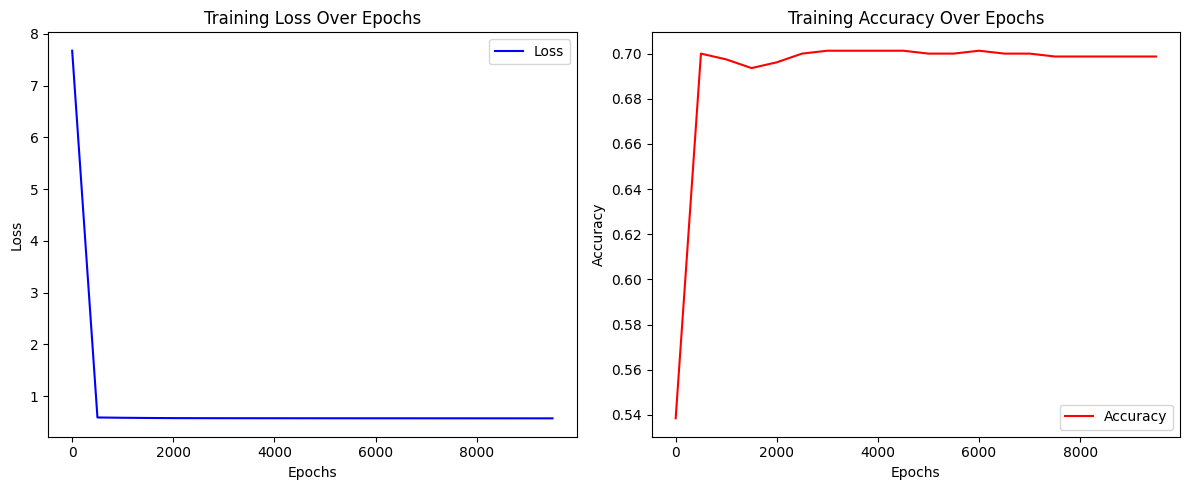

In [298]:
plot_side_by_side(epoch_arr, train_loss, train_accu, "Training")

#### Plotting Loss and Accuracy over epochs for Test Data

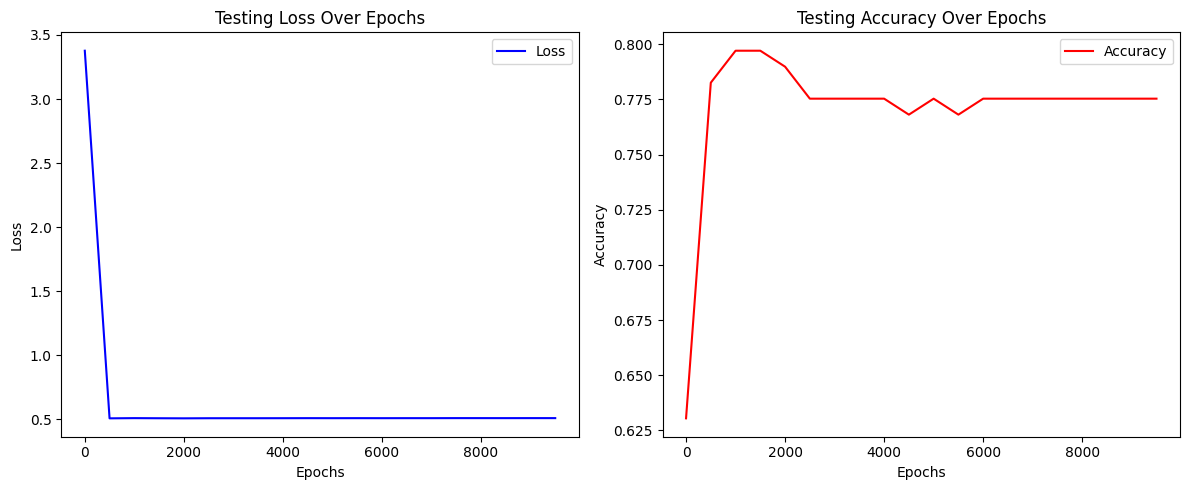

In [299]:
plot_side_by_side(epoch_arr, test_loss, test_accu, "Testing")

### Testing the model

In [300]:
model.eval()
with torch.inference_mode():
    test_output = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_output))

test_pred[:10], y_test[:10] 

(tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1.]))

### Calculating Metrics

In [301]:
accuracy = accuracy_score(y_test, test_pred)
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)

print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}')
print(f'Recall: {recall*100:.2f}')
print(f'F1 Score: {f1*100:.2f}')

Accuracy: 77.54%
Precision: 93.75
Recall: 68.97
F1 Score: 79.47


### Plotting Actual vs Predicted values

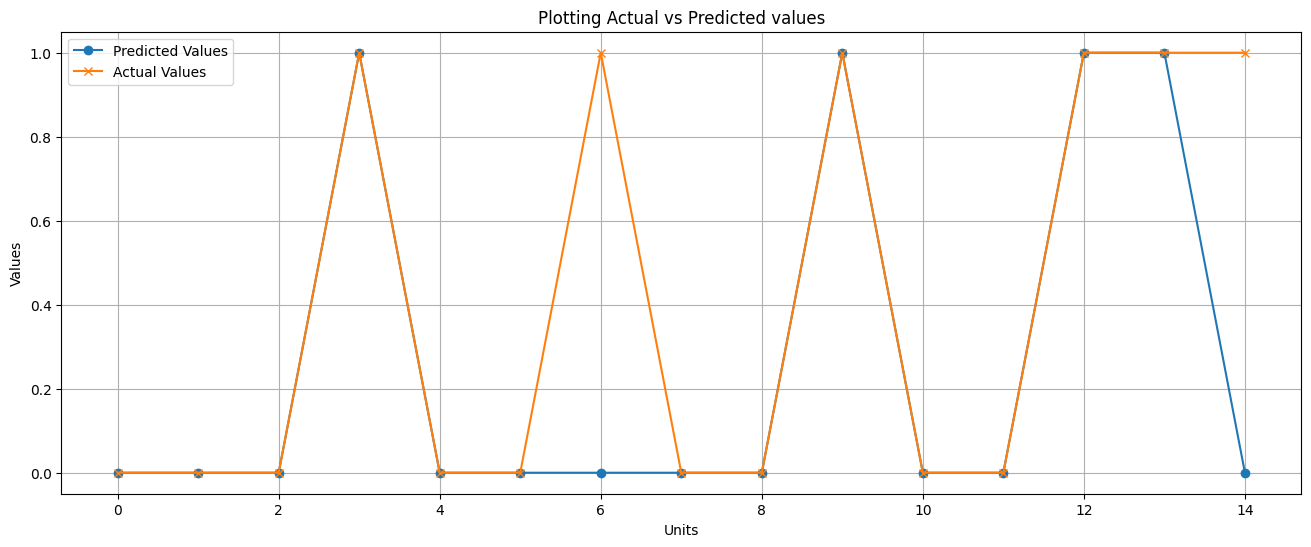

In [303]:
plt.figure(figsize=(16,6))
plt.plot(test_pred[:15], label='Predicted Values', marker='o')
plt.plot(y_test[:15], label='Actual Values', marker='x')
plt.title('Plotting Actual vs Predicted values')
plt.xlabel("Units")
plt.ylabel("Values")
plt.grid()
plt.legend()
plt.show()